# Image Classification
In this project, we'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  We'll apply max pooling, dropout, and fully connected layers.  At the end, we'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [2]:

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


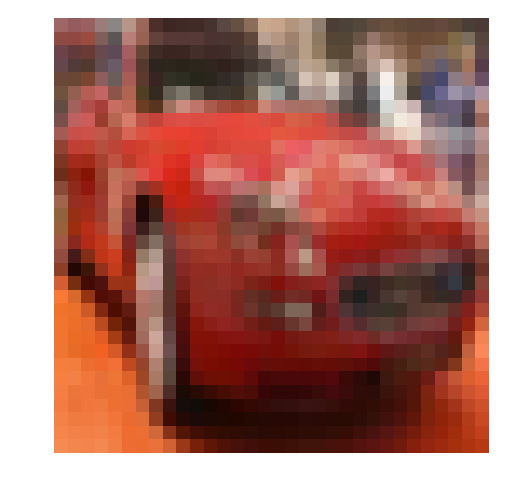

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [4]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    print(len(x[:,0,0,0]))
    
    return np.array([np.divide(x[idx],255.0) for idx in range(len(x[:,0,0,0]))])
    

tests.test_normalize(normalize)

428
Tests Passed


### One-hot encode


In [6]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    result = np.zeros(shape=(len(x), 10))
    result[np.arange(len(x)), x] = 1
    return result.astype(int)
    
    

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


# Randomize Data
As we saw from exploring the data above, the order of the samples are randomized.  

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [7]:

# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

9000
9000
9000
9000
9000
5000
10000


# Check Point
This is our first checkpoint. The preprocessed data has been saved to disk.

In [8]:

import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we'll build each layer into a function.  



### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load our saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    #print(image_shape)
    return tf.placeholder(tf.float32,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    #print(tf.placeholder(tf.float32,[None,n_classes], name="y"))
    return tf.placeholder(tf.float32,[None,n_classes], name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name='keep_prob')


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, we should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.



In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight = tf.Variable(tf.truncated_normal((conv_ksize[0],conv_ksize[1],x_tensor.shape.as_list()[3],conv_num_outputs),
                                            dtype=tf.float32,mean=0.0, stddev=0.05))
    conv = tf.nn.conv2d(x_tensor, weight,
                        strides=[1,conv_strides[0],conv_strides[1],1],padding='SAME')
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    conv = tf.nn.bias_add(conv,bias)
    conv = tf.nn.relu(conv)
    return tf.nn.max_pool(conv, ksize=[1,pool_ksize[0],pool_ksize[1],1],
                         strides=[1,pool_strides[0],pool_strides[1],1], padding='SAME')
    


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). 

In [13]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.contrib.layers.flatten(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

In [14]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    out_weight = tf.Variable(tf.truncated_normal([x_tensor.shape.as_list()[1],num_outputs], mean=0., stddev=0.05))
    out_bias = tf.Variable(tf.zeros([num_outputs]))
    x_tensor = tf.nn.bias_add(tf.matmul(x_tensor, out_weight), out_bias)
    x_tensor = tf.nn.relu(x_tensor)
    return x_tensor
    
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

In [15]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    out_weight = tf.Variable(tf.truncated_normal([x_tensor.shape.as_list()[1],num_outputs], mean=0., stddev=0.1))
    out_bias = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1))
    x_tensor = tf.nn.bias_add(tf.matmul(x_tensor, out_weight), out_bias)
    

    return x_tensor
    
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  

In [16]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    num_classes = 10
    conv_strides = (1,1)
    conv_ksize = (5,5)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    x2= conv2d_maxpool(x, 63, conv_ksize, conv_strides, pool_ksize, pool_strides)
    x2= conv2d_maxpool(x2, 128, conv_ksize, conv_strides, pool_ksize, pool_strides)
    x2= conv2d_maxpool(x2, 256, conv_ksize, conv_strides, pool_ksize, pool_strides)
    x2 = tf.contrib.layers.dropout(x2, keep_prob)
    x2 = flatten(x2)

    x3 = fully_conn(x2, 256)
    x4 = tf.contrib.layers.dropout(x3, keep_prob)
    
    x4 = fully_conn(x4, 64)
    x4 = tf.contrib.layers.dropout(x4, keep_prob)
    x5 = output(x4, num_classes)
    
    return x5



##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implementation of the function `train_neural_network` to do a single optimization.  The optimization uses `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [17]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})
    
    

tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [18]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    valid_acc = session.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    print('Loss : {}, Accuracy: {}'.format(loss,valid_acc), end='')
    print()


In [21]:
epochs = 30
batch_size = 512
keep_probability = .8

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, I've used a single batch. This should save time while we iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, we can run the model on all the data in the next section.

In [22]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        #if((epoch+1)%10 ==0):
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch+1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss : 2.1473519802093506, Accuracy: 0.17260000109672546
Epoch  2, CIFAR-10 Batch 1:  Loss : 1.840544581413269, Accuracy: 0.35280001163482666
Epoch  3, CIFAR-10 Batch 1:  Loss : 1.7229297161102295, Accuracy: 0.3846000134944916
Epoch  4, CIFAR-10 Batch 1:  Loss : 1.6378717422485352, Accuracy: 0.4041999876499176
Epoch  5, CIFAR-10 Batch 1:  Loss : 1.5361483097076416, Accuracy: 0.42419999837875366
Epoch  6, CIFAR-10 Batch 1:  Loss : 1.3974727392196655, Accuracy: 0.46299999952316284
Epoch  7, CIFAR-10 Batch 1:  Loss : 1.2381916046142578, Accuracy: 0.5070000290870667
Epoch  8, CIFAR-10 Batch 1:  Loss : 1.174689769744873, Accuracy: 0.5203999876976013
Epoch  9, CIFAR-10 Batch 1:  Loss : 1.0465023517608643, Accuracy: 0.5317999720573425
Epoch 10, CIFAR-10 Batch 1:  Loss : 0.8940780162811279, Accuracy: 0.5641999840736389
Epoch 11, CIFAR-10 Batch 1:  Loss : 0.7918235063552856, Accuracy: 0.5825999975204468
Epoch 12, CIFAR-10 B

### Fully Train the Model
Now that we got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [23]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss : 2.091264009475708, Accuracy: 0.2818000018596649
Epoch  1, CIFAR-10 Batch 2:  Loss : 1.8443857431411743, Accuracy: 0.321399986743927
Epoch  1, CIFAR-10 Batch 3:  Loss : 1.5629322528839111, Accuracy: 0.38659998774528503
Epoch  1, CIFAR-10 Batch 4:  Loss : 1.611863374710083, Accuracy: 0.38839998841285706
Epoch  1, CIFAR-10 Batch 5:  Loss : 1.4928028583526611, Accuracy: 0.44999998807907104
Epoch  2, CIFAR-10 Batch 1:  Loss : 1.5176451206207275, Accuracy: 0.47279998660087585
Epoch  2, CIFAR-10 Batch 2:  Loss : 1.3982348442077637, Accuracy: 0.49900001287460327
Epoch  2, CIFAR-10 Batch 3:  Loss : 1.1796629428863525, Accuracy: 0.5108000040054321
Epoch  2, CIFAR-10 Batch 4:  Loss : 1.170195460319519, Accuracy: 0.5370000004768372
Epoch  2, CIFAR-10 Batch 5:  Loss : 1.207588791847229, Accuracy: 0.527400016784668
Epoch  3, CIFAR-10 Batch 1:  Loss : 1.223562479019165, Accuracy: 0.555400013923645
Epoch  3, CIFAR-10 Batch 2:  Loss : 1.1122440099716187, 

# Checkpoint
The model has been saved to disk.
## Test Model
Here we test our model against the test dataset.  This will be our final accuracy. We should have an accuracy greater than 50%. If we don't, we need to keep tweaking the model architecture and parameters.

Testing Accuracy: 0.7334788590669632



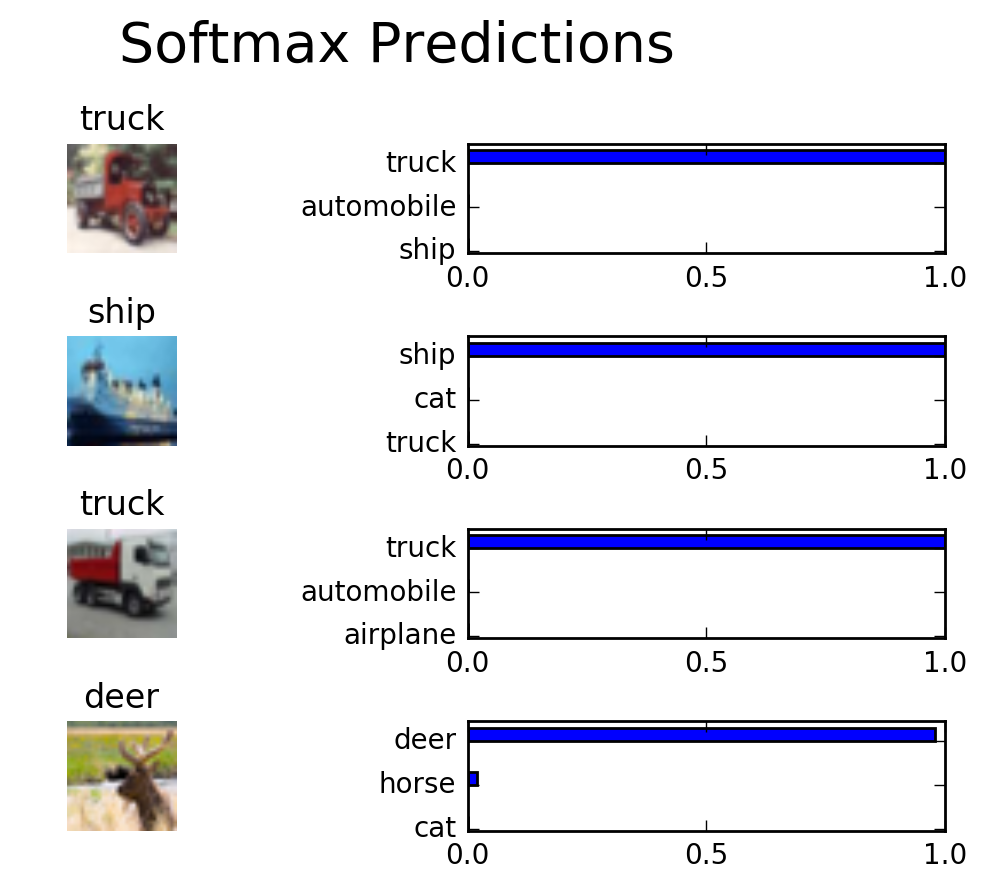

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()